In [5]:
# LSTM과 데이터 로더
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
from dezero import SeqDataLoader
import dezero.functions as F
import dezero.layers as L

In [6]:
from dezero.dataloaders import DataLoader 
import dezero
class SeqDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, gpu=False):
        super().__init__(dataset=dataset, batch_size=batch_size, shuffle=False,
                         gpu=gpu)

    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration

        jump = self.data_size // self.batch_size
        batch_index = [(i * jump + self.iteration) % self.data_size for i in
                       range(self.batch_size)]
        batch = [self.dataset[i] for i in batch_index]

        xp = cuda.cupy if self.gpu else np
        x = xp.array([example[0] for example in batch])
        t = xp.array([example[1] for example in batch])

        self.iteration += 1
        return x, t

train_set = dezero.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=3)
x, t = next(dataloader)
print(x)
print('-----------------------------')
print(t)

[[-0.0149468 ]
 [ 0.89952919]
 [-0.84857771]]
-----------------------------
[[ 0.0392302 ]
 [ 0.88235841]
 [-0.85944576]]


LSTM 수식   
![식 60.1](./img/60.1.png)      
![식 60.2](./img/60.2.png)      
![식 60.3](./img/60.3.png)      
 ${\displaystyle \bigcirc }$ : 아다마르 곱

In [ ]:
# 수식을 구현
class LSTM(Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()

        H, I = hidden_size, in_size
        self.x2f = Linear(H, in_size=I)
        self.x2i = Linear(H, in_size=I)
        self.x2o = Linear(H, in_size=I)
        self.x2u = Linear(H, in_size=I)
        self.h2f = Linear(H, in_size=H, nobias=True)
        self.h2i = Linear(H, in_size=H, nobias=True)
        self.h2o = Linear(H, in_size=H, nobias=True)
        self.h2u = Linear(H, in_size=H, nobias=True)
        self.reset_state()

    def reset_state(self):
        self.h = None
        self.c = None

    def forward(self, x):
        if self.h is None:
            f = F.sigmoid(self.x2f(x))
            i = F.sigmoid(self.x2i(x))
            o = F.sigmoid(self.x2o(x))
            u = F.tanh(self.x2u(x))
        else:
            f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
            i = F.sigmoid(self.x2i(x) + self.h2i(self.h))
            o = F.sigmoid(self.x2o(x) + self.h2o(self.h))
            u = F.tanh(self.x2u(x) + self.h2u(self.h))

        if self.c is None:
            c_new = (i * u)
        else:
            c_new = (f * self.c) + (i * u)

        h_new = o * F.tanh(c_new)

        self.h, self.c = h_new, c_new
        return h_new

| epoch 1 | loss 0.548959
| epoch 2 | loss 0.429101
| epoch 3 | loss 0.326466
| epoch 4 | loss 0.240891
| epoch 5 | loss 0.171932
| epoch 6 | loss 0.119071
| epoch 7 | loss 0.081647
| epoch 8 | loss 0.058607
| epoch 9 | loss 0.048237
| epoch 10 | loss 0.047962
| epoch 11 | loss 0.054389
| epoch 12 | loss 0.063703
| epoch 13 | loss 0.072350
| epoch 14 | loss 0.077829
| epoch 15 | loss 0.079094
| epoch 16 | loss 0.076359
| epoch 17 | loss 0.070601
| epoch 18 | loss 0.063071
| epoch 19 | loss 0.054969
| epoch 20 | loss 0.047253
| epoch 21 | loss 0.040578
| epoch 22 | loss 0.035292
| epoch 23 | loss 0.031490
| epoch 24 | loss 0.029068
| epoch 25 | loss 0.027801
| epoch 26 | loss 0.027392
| epoch 27 | loss 0.027533
| epoch 28 | loss 0.027936
| epoch 29 | loss 0.028364
| epoch 30 | loss 0.028641
| epoch 31 | loss 0.028660
| epoch 32 | loss 0.028375
| epoch 33 | loss 0.027793
| epoch 34 | loss 0.026958
| epoch 35 | loss 0.025941
| epoch 36 | loss 0.024823
| epoch 37 | loss 0.023683
| epoch 38

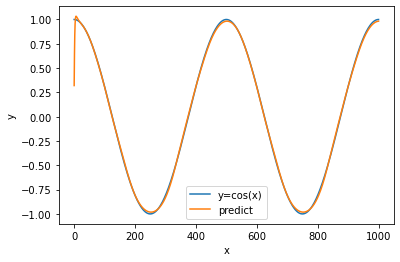

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
from dezero import SeqDataLoader
import dezero.functions as F
import dezero.layers as L


max_epoch = 100
batch_size = 30
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)         
dataloader = SeqDataLoader(train_set, batch_size=batch_size)        # 시계열용 데이터 로더 사용
seqlen = len(train_set)


class BetterRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.LSTM(hidden_size)      # LSTM 사용
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def __call__(self, x):
        y = self.rnn(x)
        y = self.fc(y)
        return y

model = BetterRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in dataloader:
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()
    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()